In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import tensorflow as tf
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in Google Drive to save results
SAVE_DIR = '/content/drive/MyDrive/NCF_Recommendation_Results101'
os.makedirs(SAVE_DIR, exist_ok=True)

# Install recommenders package
!pip install -q recommenders

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (
    map_at_k, ndcg_at_k, precision_at_k, recall_at_k
)
from recommenders.utils.constants import SEED as DEFAULT_SEED

print("System version:", sys.version)
print("Pandas version:", pd.__version__)
print("Tensorflow version:", tf.__version__)


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 10.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.3/355.3 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.5/31.5 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 70.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.2/264.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.0/113.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [2]:
TOP_K = 10
MOVIELENS_DATA_SIZE = '100k'
SEED = DEFAULT_SEED


results = {}


print("Loading MovieLens data...")
df = movielens.load_pandas_df(
    size=MOVIELENS_DATA_SIZE,
    header=["userID", "itemID", "rating", "timestamp"]
)
print(f"Data loaded: {len(df)} ratings from {df['userID'].nunique()} users on {df['itemID'].nunique()} items")


train, test = python_chrono_split(df, 0.75)
print(f"Train set size: {len(train)}, Test set size: {len(test)}")


test = test[test["userID"].isin(train["userID"].unique())]
test = test[test["itemID"].isin(train["itemID"].unique())]
leave_one_out_test = test.groupby("userID").last().reset_index()


train_file = "./train.csv"
test_file = "./test.csv"
leave_one_out_test_file = "./leave_one_out_test.csv"
train.to_csv(train_file, index=False)
test.to_csv(test_file, index=False)
leave_one_out_test.to_csv(leave_one_out_test_file, index=False)


Loading MovieLens data...


100%|██████████| 4.81k/4.81k [00:00<00:00, 4.99kKB/s]


Data loaded: 100000 ratings from 943 users on 1682 items
Train set size: 74992, Test set size: 25008


In [4]:
item_popularity = df.groupby('itemID').size().to_dict()

def calculate_diversity(topk_items, item_popularity):
    """Calculate diversity of recommendations based on item popularity."""
    avg_popularity = np.mean([item_popularity.get(item, 0) for item in topk_items['itemID'].unique()])
    unique_items = len(topk_items['itemID'].unique())
    return {
        'avg_popularity': avg_popularity,
        'unique_items': unique_items
    }

def calculate_popularity_bias(topk_items, item_popularity, top_p=0.2):
    """Calculate popularity bias in recommendations."""

    sorted_items = sorted(item_popularity.items(), key=lambda x: x[1], reverse=True)

    n_top = int(len(sorted_items) * top_p)
    top_popular = set([item for item, _ in sorted_items[:n_top]])


    reco_items = topk_items['itemID'].unique()
    top_popular_in_reco = [item for item in reco_items if item in top_popular]
    popular_ratio = len(top_popular_in_reco) / len(reco_items) if len(reco_items) > 0 else 0

    return {
        'popular_ratio': popular_ratio,
        'top_p_percent': top_p
    }

def get_top_k_items(all_predictions, train, k=10):
    """Get top-k recommendations for each user that are not in the training set."""
    # Remove items that users have already interacted with
    merged = pd.merge(all_predictions, train, on=['userID', 'itemID'], how='left')
    filtered_predictions = merged[merged['rating'].isnull()].drop('rating', axis=1)

    # Get top-k items for each user
    top_k = filtered_predictions.sort_values(['userID', 'prediction'], ascending=[True, False])
    top_k = top_k.groupby('userID').head(k).reset_index(drop=True)

    return top_k


In [5]:
def train_and_evaluate(model_type, epochs, batch_size, learning_rate=0.005):
    """Train and evaluate NCF model with given hyperparameters."""
    print(f"\n{'-'*80}")
    print(f"Training {model_type} model with {epochs} epochs, batch_size={batch_size}, lr={learning_rate}")
    print(f"{'-'*80}")


    data = NCFDataset(train_file=train_file, test_file=leave_one_out_test_file, seed=SEED, overwrite_test_file_full=True)


    model = NCF(
        n_users=data.n_users,
        n_items=data.n_items,
        model_type=model_type,
        n_factors=8,  # Increased from 4
        layer_sizes=[32, 16, 8],  # Increased from [16, 8, 4]
        n_epochs=epochs,
        batch_size=batch_size,
        learning_rate=learning_rate,
        verbose=10,
        seed=SEED
    )


    process = psutil.Process(os.getpid())
    memory_before = process.memory_info().rss / 1024 / 1024  # MB


    with Timer() as train_time:
        model.fit(data)


    memory_after = process.memory_info().rss / 1024 / 1024  # MB
    memory_used = memory_after - memory_before

    print(f"Took {train_time.interval:.2f} seconds for training.")
    print(f"Memory usage: {memory_used:.2f} MB")


    with Timer() as predict_time:
        users, items, preds = [], [], []
        all_items = list(train.itemID.unique())
        for user in train.userID.unique():
            user_items = [user] * len(all_items)
            users.extend(user_items)
            items.extend(all_items)


        batch_size_pred = 100000
        all_preds = []
        for i in range(0, len(users), batch_size_pred):
            batch_users = users[i:i+batch_size_pred]
            batch_items = items[i:i+batch_size_pred]
            batch_preds = model.predict(batch_users, batch_items, is_list=True)
            all_preds.extend(batch_preds)

        all_predictions = pd.DataFrame(data={"userID": users, "itemID": items, "prediction": all_preds})

    print(f"Took {predict_time.interval:.2f} seconds for prediction.")


    merged = pd.merge(all_predictions, train, on=["userID", "itemID"], how="left")
    filtered_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)


    eval_map = map_at_k(test, filtered_predictions, col_prediction='prediction', k=TOP_K)
    eval_ndcg = ndcg_at_k(test, filtered_predictions, col_prediction='prediction', k=TOP_K)
    eval_precision = precision_at_k(test, filtered_predictions, col_prediction='prediction', k=TOP_K)
    eval_recall = recall_at_k(test, filtered_predictions, col_prediction='prediction', k=TOP_K)

    print(f"MAP@{TOP_K}: {eval_map:.4f}")
    print(f"NDCG@{TOP_K}: {eval_ndcg:.4f}")
    print(f"Precision@{TOP_K}: {eval_precision:.4f}")
    print(f"Recall@{TOP_K}: {eval_recall:.4f}")


    top_k_recs = get_top_k_items(filtered_predictions, train, k=TOP_K)


    diversity_metrics = calculate_diversity(top_k_recs, item_popularity)
    popularity_bias_metrics = calculate_popularity_bias(top_k_recs, item_popularity)

    print(f"Average item popularity: {diversity_metrics['avg_popularity']:.2f}")
    print(f"Unique items recommended: {diversity_metrics['unique_items']}")
    print(f"Popular item ratio: {popularity_bias_metrics['popular_ratio']:.2f}")

    # Evaluate on leave-one-out test set
    k = TOP_K
    ndcgs = []
    hit_ratio = []

    for b in data.test_loader():
        user_input, item_input, labels = b
        output = model.predict(user_input, item_input, is_list=True)
        output = np.squeeze(output)
        rank = sum(output >= output[0])
        if rank <= k:
            ndcgs.append(1 / np.log(rank + 1))
            hit_ratio.append(1)
        else:
            ndcgs.append(0)
            hit_ratio.append(0)

    eval_ndcg_loo = np.mean(ndcgs)
    eval_hr = np.mean(hit_ratio)

    print(f"HR@{TOP_K}: {eval_hr:.4f}")
    print(f"NDCG@{TOP_K} (leave-one-out): {eval_ndcg_loo:.4f}")

    # Store results
    config_name = f"{model_type}_epochs{epochs}_batch{batch_size}"
    results[config_name] = {
        "model_type": model_type,
        "epochs": epochs,
        "batch_size": batch_size,
        "learning_rate": learning_rate,
        "train_time": train_time.interval,
        "predict_time": predict_time.interval,
        "memory_used_mb": memory_used,
        "map": eval_map,
        "ndcg": eval_ndcg,
        "precision": eval_precision,
        "recall": eval_recall,
        "hr": eval_hr,
        "ndcg_loo": eval_ndcg_loo,
        "avg_popularity": diversity_metrics['avg_popularity'],
        "unique_items": diversity_metrics['unique_items'],
        "popular_ratio": popularity_bias_metrics['popular_ratio']
    }

    # Save model
    model_save_path = os.path.join(SAVE_DIR, config_name)
    os.makedirs(model_save_path, exist_ok=True)
    model.save(model_save_path)

    return results[config_name]

In [6]:
hyperparameters = [
    ("NeuMF", 50, 256),
    ("NeuMF", 50, 1024),
    ("NeuMF", 100, 256),
    ("NeuMF", 100, 1024),
    ("GMF", 50, 256),
    ("GMF", 50, 1024),
    ("GMF", 100, 256),
    ("GMF", 100, 1024),
]

# Train and evaluate models with different hyperparameters
for model_type, epochs, batch_size in hyperparameters:
    train_and_evaluate(model_type, epochs, batch_size)

# Convert results to DataFrame and save to CSV
results_df = pd.DataFrame.from_dict(results, orient='index')
results_path = os.path.join(SAVE_DIR, 'results.csv')
results_df.to_csv(results_path)
print(f"Results saved to {results_path}")


--------------------------------------------------------------------------------
Training NeuMF model with 50 epochs, batch_size=256, lr=0.005
--------------------------------------------------------------------------------


100%|██████████| 943/943 [00:03<00:00, 278.91it/s]


Took 309.03 seconds for training.
Memory usage: 35.70 MB
Took 3.64 seconds for prediction.
MAP@10: 0.1005
NDCG@10: 0.1972
Precision@10: 0.1775
Recall@10: 0.0995
Average item popularity: 110.94
Unique items recommended: 786
Popular item ratio: 0.42
HR@10: 0.5016
NDCG@10 (leave-one-out): 0.3916

--------------------------------------------------------------------------------
Training NeuMF model with 50 epochs, batch_size=1024, lr=0.005
--------------------------------------------------------------------------------


100%|██████████| 943/943 [00:03<00:00, 286.00it/s]


Took 216.04 seconds for training.
Memory usage: 15.59 MB
Took 2.84 seconds for prediction.
MAP@10: 0.0995
NDCG@10: 0.1960
Precision@10: 0.1773
Recall@10: 0.1012
Average item popularity: 103.70
Unique items recommended: 873
Popular item ratio: 0.38
HR@10: 0.5122
NDCG@10 (leave-one-out): 0.4210

--------------------------------------------------------------------------------
Training NeuMF model with 100 epochs, batch_size=256, lr=0.005
--------------------------------------------------------------------------------


100%|██████████| 943/943 [00:04<00:00, 204.51it/s]


Took 625.44 seconds for training.
Memory usage: 50.47 MB
Took 3.02 seconds for prediction.
MAP@10: 0.0949
NDCG@10: 0.1886
Precision@10: 0.1697
Recall@10: 0.0938
Average item popularity: 105.11
Unique items recommended: 855
Popular item ratio: 0.39
HR@10: 0.5027
NDCG@10 (leave-one-out): 0.3999

--------------------------------------------------------------------------------
Training NeuMF model with 100 epochs, batch_size=1024, lr=0.005
--------------------------------------------------------------------------------


100%|██████████| 943/943 [00:04<00:00, 233.85it/s]


Took 438.15 seconds for training.
Memory usage: 46.72 MB
Took 2.97 seconds for prediction.
MAP@10: 0.0958
NDCG@10: 0.1912
Precision@10: 0.1721
Recall@10: 0.0993
Average item popularity: 103.57
Unique items recommended: 877
Popular item ratio: 0.38
HR@10: 0.5037
NDCG@10 (leave-one-out): 0.3881

--------------------------------------------------------------------------------
Training GMF model with 50 epochs, batch_size=256, lr=0.005
--------------------------------------------------------------------------------


100%|██████████| 943/943 [00:04<00:00, 202.28it/s]


Took 254.09 seconds for training.
Memory usage: 44.04 MB
Took 3.45 seconds for prediction.
MAP@10: 0.1147
NDCG@10: 0.2129
Precision@10: 0.1914
Recall@10: 0.1074
Average item popularity: 129.01
Unique items recommended: 603
Popular item ratio: 0.53
HR@10: 0.5398
NDCG@10 (leave-one-out): 0.4208

--------------------------------------------------------------------------------
Training GMF model with 50 epochs, batch_size=1024, lr=0.005
--------------------------------------------------------------------------------


100%|██████████| 943/943 [00:03<00:00, 274.09it/s]


Took 189.30 seconds for training.
Memory usage: 49.27 MB
Took 2.68 seconds for prediction.
MAP@10: 0.1171
NDCG@10: 0.2146
Precision@10: 0.1922
Recall@10: 0.1065
Average item popularity: 129.40
Unique items recommended: 606
Popular item ratio: 0.54
HR@10: 0.5387
NDCG@10 (leave-one-out): 0.4292

--------------------------------------------------------------------------------
Training GMF model with 100 epochs, batch_size=256, lr=0.005
--------------------------------------------------------------------------------


100%|██████████| 943/943 [00:04<00:00, 235.33it/s]


Took 508.00 seconds for training.
Memory usage: 48.62 MB
Took 2.63 seconds for prediction.
MAP@10: 0.1145
NDCG@10: 0.2106
Precision@10: 0.1866
Recall@10: 0.1039
Average item popularity: 128.07
Unique items recommended: 612
Popular item ratio: 0.52
HR@10: 0.5461
NDCG@10 (leave-one-out): 0.4354

--------------------------------------------------------------------------------
Training GMF model with 100 epochs, batch_size=1024, lr=0.005
--------------------------------------------------------------------------------


100%|██████████| 943/943 [00:04<00:00, 204.90it/s]


Took 380.73 seconds for training.
Memory usage: 0.51 MB
Took 2.59 seconds for prediction.
MAP@10: 0.1186
NDCG@10: 0.2180
Precision@10: 0.1963
Recall@10: 0.1112
Average item popularity: 127.49
Unique items recommended: 616
Popular item ratio: 0.53
HR@10: 0.5334
NDCG@10 (leave-one-out): 0.4239
Results saved to /content/drive/MyDrive/NCF_Recommendation_Results/results.csv


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
System version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
Pandas version: 2.2.2
Tensorflow version: 2.18.0
Loading MovieLens data...


100%|██████████| 4.81k/4.81k [00:00<00:00, 5.01kKB/s]


Data loaded: 100000 ratings from 943 users on 1682 items
User interaction statistics:
  Min: 20, Max: 737, Median: 65.0, Mean: 106.0
Item interaction statistics:
  Min: 1, Max: 583, Median: 27.0, Mean: 59.5
Interaction buckets:
  1-28: 187 entities
  29-49: 188 entities
  50-92: 187 entities
  93-170: 190 entities
  171+: 191 entities
Interaction buckets:
  1-4: 333 entities
  5-15: 339 entities
  16-42: 332 entities
  43-99: 340 entities
  100+: 338 entities
Train set size: 74992, Test set size: 25008

--------------------------------------------------------------------------------
Training NeuMF model with 50 epochs, batch_size=1024, lr=0.005
--------------------------------------------------------------------------------
Model training completed in 217.39 seconds
Model saved to /content/drive/MyDrive/NCF_Cold_Start_Results/NeuMF_epochs50_batch1024

Performing cold-start analysis...

Cold-start USER analysis:
Evaluating user bucket: 1-28
Generating predictions for 187 users and 1597 

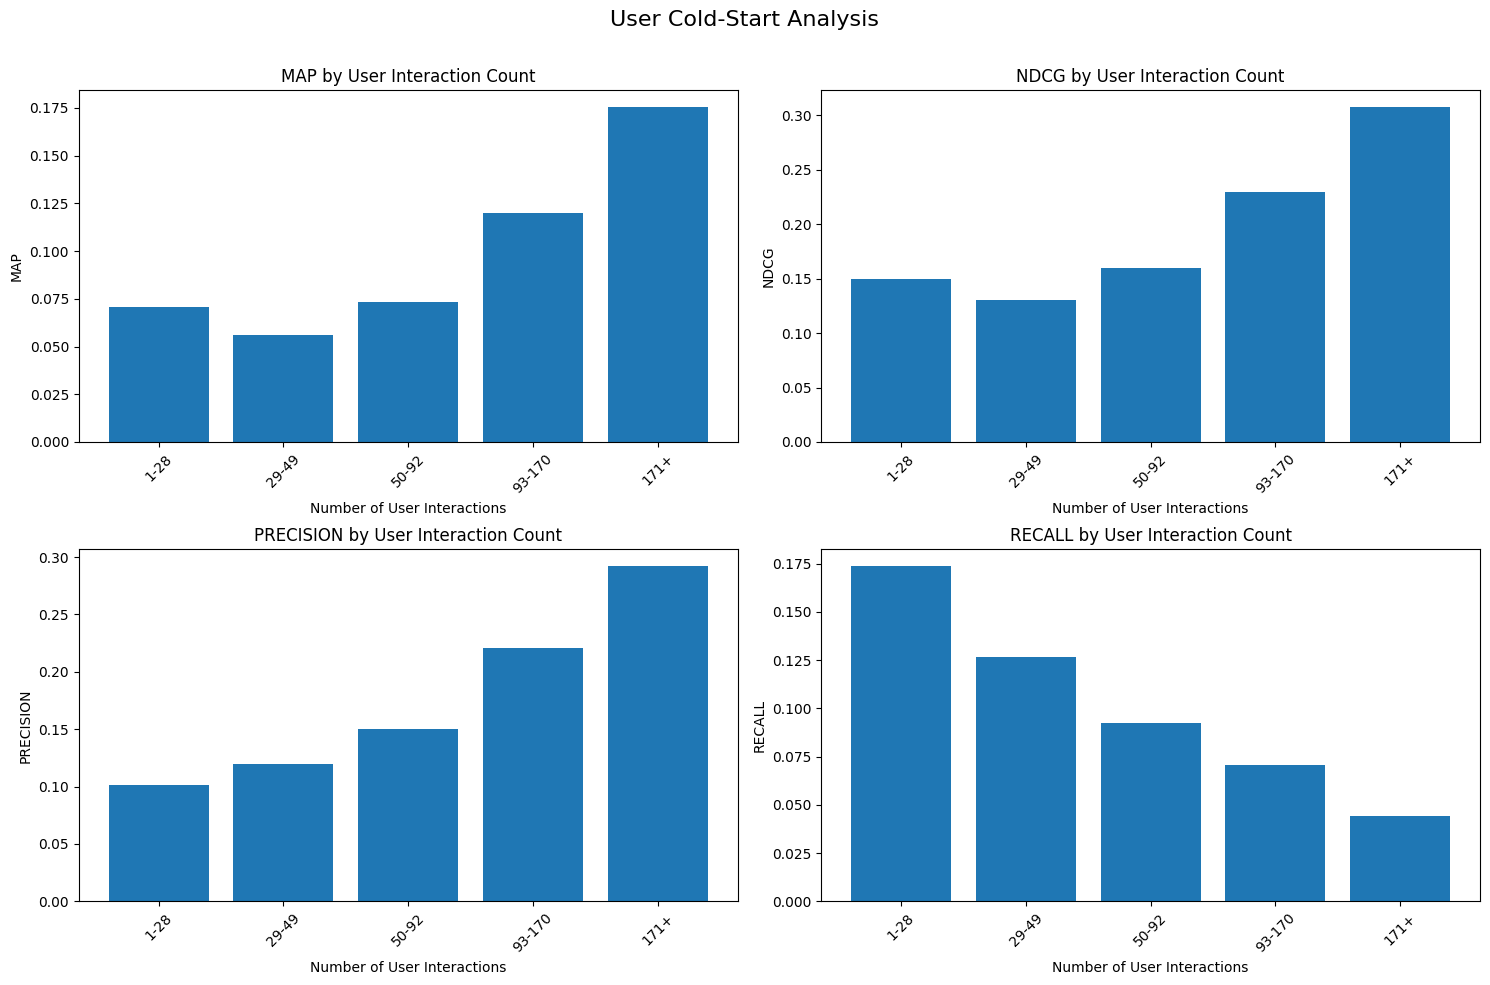

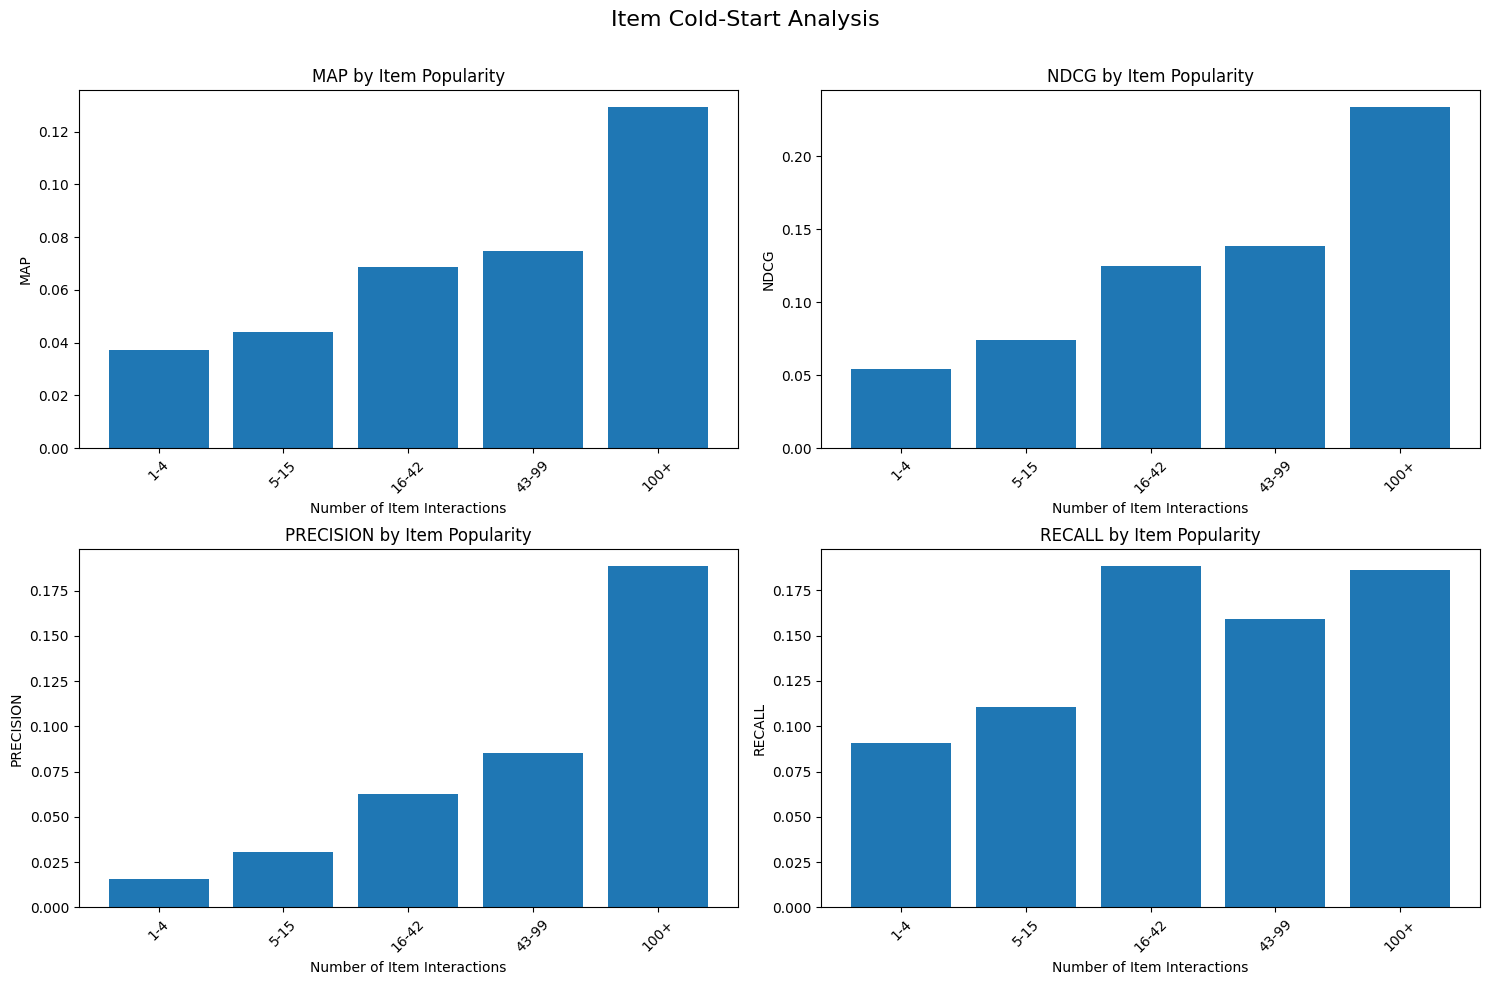

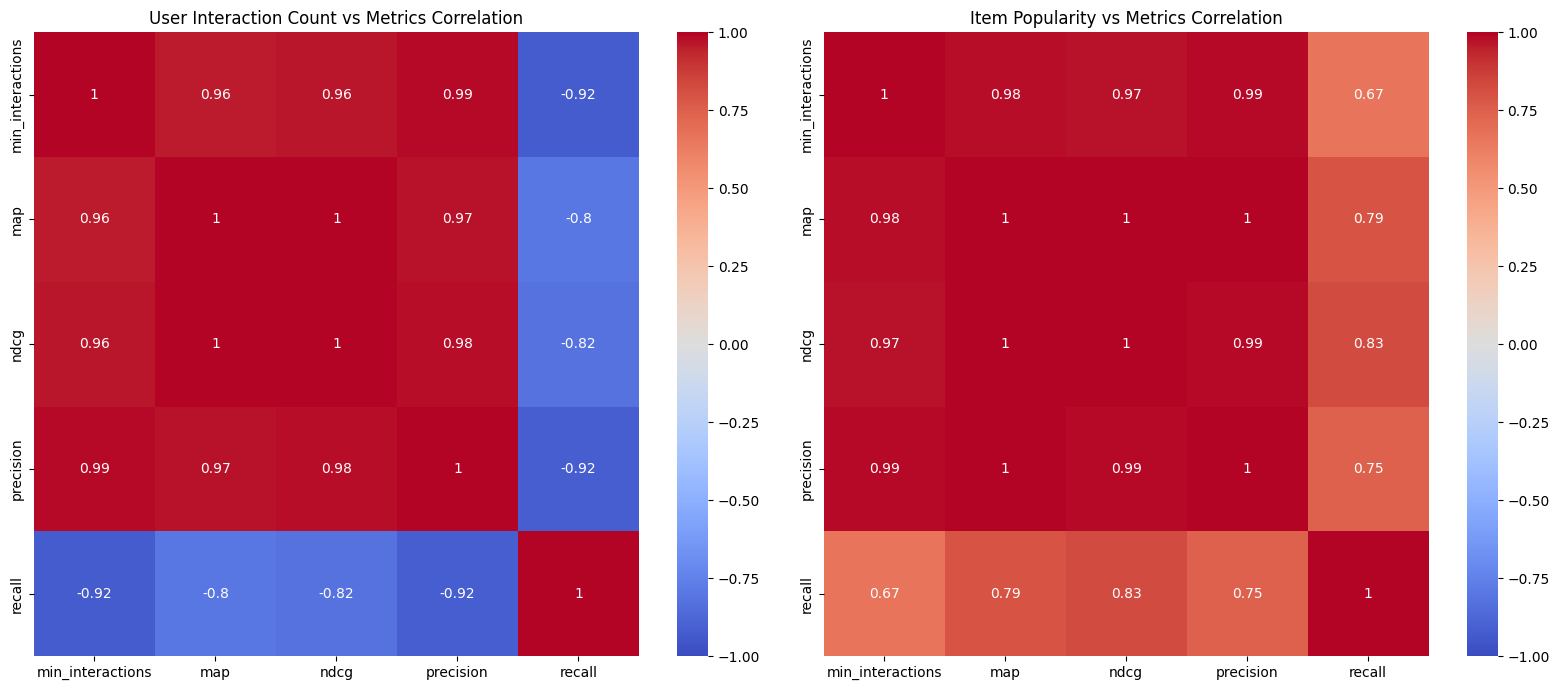

In [8]:
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import gc
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in Google Drive to save results
SAVE_DIR = '/content/drive/MyDrive/NCF_Cold_Start_Results'
os.makedirs(SAVE_DIR, exist_ok=True)

# Install recommenders package
!pip install -q recommenders

from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (
    map_at_k, ndcg_at_k, precision_at_k, recall_at_k
)
from recommenders.utils.constants import SEED as DEFAULT_SEED

print("System version:", sys.version)
print("Pandas version:", pd.__version__)
print("Tensorflow version:", tf.__version__)

# Set parameters
TOP_K = 10
MOVIELENS_DATA_SIZE = '100k'
SEED = DEFAULT_SEED  # Set None for non-deterministic results
EPOCHS = 50
BATCH_SIZE = 1024
LEARNING_RATE = 0.005
MODEL_TYPE = "NeuMF"  # Use NeuMF as the default model type

def count_interactions(df, column_name):
    """Count interactions per user/item"""
    return df.groupby(column_name).size()

def create_interaction_buckets(counts, num_buckets=5):
    """Create buckets based on number of interactions"""
    # Get quantiles to create roughly equal-sized buckets
    quantiles = np.linspace(0, 1, num_buckets + 1)[1:-1]
    thresholds = [1] + [int(t) for t in np.quantile(counts, quantiles)] + [float('inf')]

    # Create buckets
    buckets = {}
    for i in range(len(thresholds) - 1):
        min_val = thresholds[i]
        max_val = thresholds[i+1]
        if min_val == max_val:
            bucket_name = f"{min_val}"
        else:
            bucket_name = f"{min_val}-{max_val-1}" if max_val != float('inf') else f"{min_val}+"

        buckets[bucket_name] = [id for id, count in counts.items()
                               if min_val <= count < max_val]

    print("Interaction buckets:")
    for bucket, ids in buckets.items():
        print(f"  {bucket}: {len(ids)} entities")

    return buckets

def generate_predictions(model, train, users=None):
    """Generate predictions for all user-item pairs not in training data"""
    users_to_predict = users if users is not None else train.userID.unique()
    all_items = list(train.itemID.unique())

    print(f"Generating predictions for {len(users_to_predict)} users and {len(all_items)} items...")

    all_predictions = pd.DataFrame()
    batch_size = 1000  # Process users in batches to prevent memory issues

    for i in range(0, len(users_to_predict), batch_size):
        batch_users = users_to_predict[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{(len(users_to_predict)-1)//batch_size + 1}")

        batch_predictions = []
        for user in batch_users:
            user_items = [user] * len(all_items)
            preds = model.predict(user_items, all_items, is_list=True)
            for j, item in enumerate(all_items):
                batch_predictions.append((user, item, preds[j]))

        batch_df = pd.DataFrame(batch_predictions, columns=["userID", "itemID", "prediction"])
        all_predictions = pd.concat([all_predictions, batch_df])

    # Filter out items that users have already interacted with
    merged = pd.merge(all_predictions, train, on=["userID", "itemID"], how="left")
    filtered_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

    return filtered_predictions

def get_topk_recommendations(all_predictions, k=10):
    """Get top-k items for each user from predictions"""
    return all_predictions.sort_values(["userID", "prediction"], ascending=[True, False]) \
                         .groupby('userID').head(k).reset_index(drop=True)

def evaluate_cold_start(model, test_df, buckets, entity_type, train_df, k=10):
    """Evaluate model performance on different cold-start buckets"""
    results = {}

    for bucket, ids in buckets.items():
        print(f"Evaluating {entity_type} bucket: {bucket}")

        # Filter test data based on bucket
        if entity_type == 'user':
            bucket_test = test_df[test_df['userID'].isin(ids)]
            # Generate predictions only for users in this bucket
            predictions = generate_predictions(model, train_df, users=np.array(ids))
        else:  # item
            bucket_test = test_df[test_df['itemID'].isin(ids)]
            # For item cold start, we need predictions for all users but will only evaluate on specific items
            predictions = generate_predictions(model, train_df)
            predictions = predictions[predictions['itemID'].isin(ids)]

        if len(bucket_test) == 0:
            print(f"  No test data for {entity_type} bucket {bucket}, skipping")
            continue

        # Calculate metrics
        bucket_results = {}
        bucket_results['count'] = len(bucket_test)
        bucket_results['map'] = map_at_k(bucket_test, predictions, k=k)
        bucket_results['ndcg'] = ndcg_at_k(bucket_test, predictions, k=k)
        bucket_results['precision'] = precision_at_k(bucket_test, predictions, k=k)
        bucket_results['recall'] = recall_at_k(bucket_test, predictions, k=k)

        results[bucket] = bucket_results
        print(f"  MAP: {bucket_results['map']:.4f}, NDCG: {bucket_results['ndcg']:.4f}")

    return results

def plot_cold_start_results(user_results, item_results, save_dir):
    """Create visualizations of cold-start analysis results"""
    metrics = ['map', 'ndcg', 'precision', 'recall']

    # Convert results to DataFrames
    user_df = pd.DataFrame.from_dict(user_results, orient='index')
    item_df = pd.DataFrame.from_dict(item_results, orient='index')

    # Plot user cold-start results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('User Cold-Start Analysis', fontsize=16)

    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        ax.bar(user_df.index, user_df[metric])
        ax.set_title(f'{metric.upper()} by User Interaction Count')
        ax.set_xlabel('Number of User Interactions')
        ax.set_ylabel(metric.upper())
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(os.path.join(save_dir, 'user_cold_start_analysis.png'))

    # Plot item cold-start results
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Item Cold-Start Analysis', fontsize=16)

    for i, metric in enumerate(metrics):
        ax = axes[i//2, i%2]
        ax.bar(item_df.index, item_df[metric])
        ax.set_title(f'{metric.upper()} by Item Popularity')
        ax.set_xlabel('Number of Item Interactions')
        ax.set_ylabel(metric.upper())
        for tick in ax.get_xticklabels():
            tick.set_rotation(45)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.savefig(os.path.join(save_dir, 'item_cold_start_analysis.png'))

    # Create correlation heatmap: interaction count vs metrics
    user_index_values = [s.split('-')[0] if '-' in s else s.replace('+', '') for s in user_df.index]
    user_df['min_interactions'] = pd.to_numeric(user_index_values)

    item_index_values = [s.split('-')[0] if '-' in s else s.replace('+', '') for s in item_df.index]
    item_df['min_interactions'] = pd.to_numeric(item_index_values)

    # Calculate correlation between interaction count and metrics
    user_corr = user_df[['min_interactions'] + metrics].corr()
    item_corr = item_df[['min_interactions'] + metrics].corr()

    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    sns.heatmap(user_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[0])
    axes[0].set_title('User Interaction Count vs Metrics Correlation')

    sns.heatmap(item_corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, ax=axes[1])
    axes[1].set_title('Item Popularity vs Metrics Correlation')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'cold_start_correlation_analysis.png'))

    return user_df, item_df

def main():
    print("Loading MovieLens data...")
    df = movielens.load_pandas_df(
        size=MOVIELENS_DATA_SIZE,
        header=["userID", "itemID", "rating", "timestamp"]
    )
    print(f"Data loaded: {len(df)} ratings from {df['userID'].nunique()} users on {df['itemID'].nunique()} items")

    # Count interactions per user and item
    user_counts = count_interactions(df, 'userID')
    item_counts = count_interactions(df, 'itemID')

    print(f"User interaction statistics:")
    print(f"  Min: {user_counts.min()}, Max: {user_counts.max()}, Median: {user_counts.median():.1f}, Mean: {user_counts.mean():.1f}")
    print(f"Item interaction statistics:")
    print(f"  Min: {item_counts.min()}, Max: {item_counts.max()}, Median: {item_counts.median():.1f}, Mean: {item_counts.mean():.1f}")

    # Create buckets based on interaction counts
    user_buckets = create_interaction_buckets(user_counts)
    item_buckets = create_interaction_buckets(item_counts)

    # Split data into train and test sets
    train, test = python_chrono_split(df, 0.75)
    print(f"Train set size: {len(train)}, Test set size: {len(test)}")

    # Ensure users and items in test set are also in train set (avoid true cold-start for this analysis)
    test = test[test["userID"].isin(train["userID"].unique())]
    test = test[test["itemID"].isin(train["itemID"].unique())]

    # Save datasets to files for NCF dataset creation
    train_file = "./train.csv"
    test_file = "./test.csv"
    train.to_csv(train_file, index=False)
    test.to_csv(test_file, index=False)

    # Create NCF dataset
    data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED)

    print(f"\n{'-'*80}")
    print(f"Training {MODEL_TYPE} model with {EPOCHS} epochs, batch_size={BATCH_SIZE}, lr={LEARNING_RATE}")
    print(f"{'-'*80}")

    # Initialize model
    model = NCF(
        n_users=data.n_users,
        n_items=data.n_items,
        model_type=MODEL_TYPE,
        n_factors=8,
        layer_sizes=[32, 16, 8],
        n_epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        verbose=10,
        seed=SEED
    )

    # Train model
    with Timer() as train_time:
        model.fit(data)

    print(f"Model training completed in {train_time.interval:.2f} seconds")

    # Save the model
    model_save_path = os.path.join(SAVE_DIR, f"{MODEL_TYPE}_epochs{EPOCHS}_batch{BATCH_SIZE}")
    os.makedirs(model_save_path, exist_ok=True)
    model.save(model_save_path)
    print(f"Model saved to {model_save_path}")

    # Perform cold-start analysis
    print("\nPerforming cold-start analysis...")

    # Cold-start user analysis
    print("\nCold-start USER analysis:")
    user_results = evaluate_cold_start(model, test, user_buckets, 'user', train, k=TOP_K)

    # Cold-start item analysis
    print("\nCold-start ITEM analysis:")
    item_results = evaluate_cold_start(model, test, item_buckets, 'item', train, k=TOP_K)

    # Plot and save results
    user_df, item_df = plot_cold_start_results(user_results, item_results, SAVE_DIR)

    # Save results to CSV
    user_df.to_csv(os.path.join(SAVE_DIR, 'user_cold_start_results.csv'))
    item_df.to_csv(os.path.join(SAVE_DIR, 'item_cold_start_results.csv'))

    # Aggregate results for reporting
    print("\nCold-start Performance Summary:")
    print("User interaction level impact on performance:")
    for metric in ['map', 'ndcg', 'precision', 'recall']:
        print(f"  {metric.upper()}: {' | '.join([f'{bucket}: {row[metric]:.4f}' for bucket, row in user_df.iterrows()])}")

    print("\nItem interaction level impact on performance:")
    for metric in ['map', 'ndcg', 'precision', 'recall']:
        print(f"  {metric.upper()}: {' | '.join([f'{bucket}: {row[metric]:.4f}' for bucket, row in item_df.iterrows()])}")

    print(f"\nCold-start analysis completed. Results saved to {SAVE_DIR}")

if __name__ == "__main__":
    main()